In [1]:
!ls

brain_clusters.h5ad    EDA.ipynb
brain_counts.csv       FACS
brain_metadata.csv     glioblastoma_normalized.h5ad
brain_normalized.h5ad  glioblastoma_raw.h5ad
brain_qc.h5ad	       pbmc3k.h5ad
brain_raw.h5ad	       prepare_data.sh
droplet		       singlecell-rnaseq-data-from-mouse-brain.zip


In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
from scanpy.tl import louvain
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from scipy.stats import ttest_ind

%matplotlib inline

In [3]:
count_df = pd.read_csv('./brain_counts.csv', index_col=0)
count_df.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610008F07Rik,0610009B14Rik,0610009B22Rik,...,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6,zsGreen_transgene
A1.B003290.3_38_F.1.1,0,125,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,54,0
A1.B003728.3_56_F.1.1,0,0,0,0,0,324,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1.MAA000560.3_10_M.1.1,0,348,0,0,0,5,0,0,0,0,...,0,0,0,0,0,195,0,0,113,0
A1.MAA000564.3_10_M.1.1,0,41,36,0,0,24,0,0,0,14,...,0,0,0,0,125,0,1,0,0,0
A1.MAA000923.3_9_M.1.1,0,53,0,0,0,0,0,0,0,0,...,0,0,0,81,0,0,0,0,0,0


In [4]:
count_df.shape

(3401, 23433)

In [5]:
metadata_df = pd.read_csv('./brain_metadata.csv', index_col=0)
metadata_df.head()

,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode
cell,,,,,
A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290
A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728
A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560
A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564
A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923


In [6]:
metadata_df.shape

(3401, 5)

In [7]:
pd.value_counts(metadata_df['subtissue'])

Cortex         1149
Hippocampus     976
Striatum        723
Cerebellum      553
Name: subtissue, dtype: int64

In [8]:
adata = sc.AnnData(X=count_df, obs=metadata_df)
adata.shape

/tmp/ipykernel_159838/2622896323.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X=count_df, obs=metadata_df)


(3401, 23433)

In [9]:
adata.X

array([[  0., 125.,  16., ...,   0.,  54.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0., 348.,   0., ...,   0., 113.,   0.],
       ...,
       [  0., 135.,  41., ...,   0.,  45.,   0.],
       [  0., 129.,  54., ...,   0.,  57.,   0.],
       [  0.,   1.,   0., ...,   0.,   0.,   0.]], dtype=float32)

## Find Spike-ins

In [10]:
is_spike_in = {}
number_of_spike_ins = 0

for gene_name in adata.var_names:
    if 'ERCC' in gene_name:
        is_spike_in[gene_name] = True # record that we found a spike-in
        number_of_spike_ins += 1 # bump the counter
    else:
        is_spike_in[gene_name] = False # record that this was not a spike-in
        
adata.var['ERCC'] = pd.Series(is_spike_in) # because the index of adata.var and the keys of is_spike_in match, anndata will take care of matching them up
print('found this many spike ins: ', number_of_spike_ins)

found this many spike ins:  92


In [11]:
adata.var.head()

,ERCC
0610005C13Rik,False
0610007C21Rik,False
0610007L01Rik,False
0610007N19Rik,False
0610007P08Rik,False


In [12]:
adata.write('brain_raw.h5ad')

## QC

In [13]:
qc = sc.pp.calculate_qc_metrics(adata, qc_vars=['ERCC'])

cell_qc_df = qc[0]
gene_qc_df = qc[1]

In [14]:
cell_qc_df.head()

,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_ERCC,log1p_total_counts_ERCC,pct_counts_ERCC
cell,,,,,,,,,,,
A1.B003290.3_38_F.1.1,3359,8.119696,390075.0,12.874097,25.884766,32.847017,42.219573,59.472666,10201.0,9.230339,2.615138
A1.B003728.3_56_F.1.1,1718,7.449498,776439.0,13.562474,43.051933,52.912721,65.313309,87.315423,67351.0,11.117688,8.674345
A1.MAA000560.3_10_M.1.1,3910,8.271548,1616087.0,14.295519,44.066006,51.514553,60.164211,74.451190,29870.0,10.304644,1.848292
A1.MAA000564.3_10_M.1.1,4352,8.378621,360004.0,12.793873,41.650926,48.958623,56.997422,69.736170,2592.0,7.860571,0.719992
A1.MAA000923.3_9_M.1.1,2248,7.718241,290282.0,12.578611,63.392494,69.136908,77.168753,90.522320,11002.0,9.305923,3.790107


In [15]:
gene_qc_df.head()

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
0610005C13Rik,28,0.118201,0.111721,99.176713,402.0,5.998937
0610007C21Rik,2399,206.211990,5.333742,29.461923,701327.0,13.460731
0610007L01Rik,961,35.938549,3.609256,71.743605,122227.0,11.713643
0610007N19Rik,272,6.498383,2.014687,92.002352,22101.0,10.003424
0610007P08Rik,582,16.328728,2.852366,82.887386,55534.0,10.924768


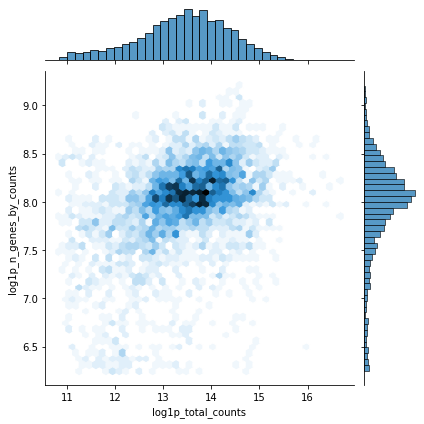

In [16]:
sns.jointplot(data=cell_qc_df,
              x='log1p_total_counts',
              y='log1p_n_genes_by_counts',
              kind='hex')

<AxesSubplot:xlabel='pct_counts_ERCC', ylabel='Count'>

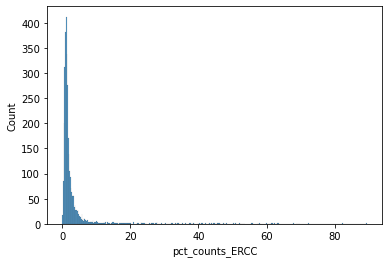

In [17]:
sns.histplot(cell_qc_df['pct_counts_ERCC'])

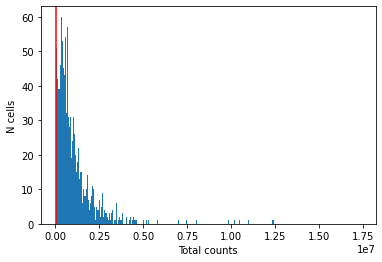

In [18]:
plt.hist(cell_qc_df['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('N cells')
plt.axvline(50000, color='red')

In [19]:
sum(cell_qc_df['total_counts'] < 50000)

0

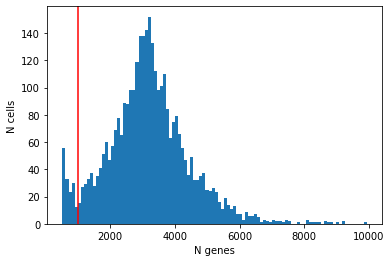

In [20]:
plt.hist(cell_qc_df['n_genes_by_counts'], bins=100)
plt.xlabel('N genes')
plt.ylabel('N cells')
plt.axvline(1000, color='red')

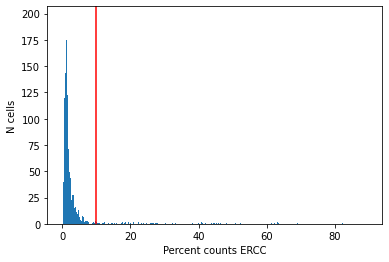

In [21]:
plt.hist(cell_qc_df['pct_counts_ERCC'], bins=1000)
plt.xlabel('Percent counts ERCC')
plt.ylabel('N cells')
plt.axvline(10, color='red')

In [22]:
low_ERCC_mask = (cell_qc_df['pct_counts_ERCC'] < 10)
adata = adata[low_ERCC_mask]

In [23]:
print('Started with: \n', adata)
sc.pp.filter_cells(adata, min_genes = 750)
print('Finished with: \n', adata)

Started with: 
 View of AnnData object with n_obs × n_vars = 3218 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode'
    var: 'ERCC'


/home/kiddos/.local/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Finished with: 
 AnnData object with n_obs × n_vars = 3210 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC'


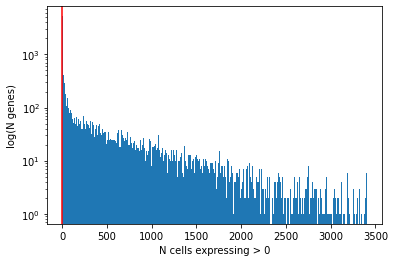

In [24]:
plt.hist(gene_qc_df['n_cells_by_counts'], bins=1000)
plt.xlabel('N cells expressing > 0')
plt.ylabel('log(N genes)') # for visual clarity
plt.axvline(2, color='red')
plt.yscale('log') 

In [25]:
sum(gene_qc_df['n_cells_by_counts'] < 2)

3969

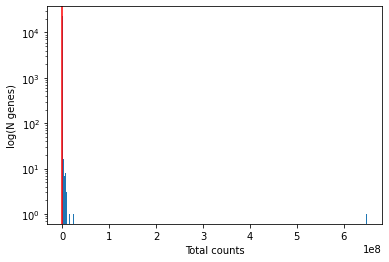

In [26]:
plt.hist(gene_qc_df['total_counts'], bins=1000)
plt.xlabel('Total counts')
plt.ylabel('log(N genes)') # for visual clarity
plt.yscale('log') 
plt.axvline(10, color='red')

In [27]:
sum(gene_qc_df['total_counts'] < 10)

4432

In [28]:
print('Started with: \n', adata)
sc.pp.filter_genes(adata, min_cells=2)
sc.pp.filter_genes(adata, min_counts=10)
print('Finished with: \n', adata)

Started with: 
 AnnData object with n_obs × n_vars = 3210 × 23433
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC'
Finished with: 
 AnnData object with n_obs × n_vars = 3210 × 18585
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes'
    var: 'ERCC', 'n_cells', 'n_counts'


In [29]:
adata.write('brain_qc.h5ad')

## Normalization

In [30]:
sc.pp.pca(adata)

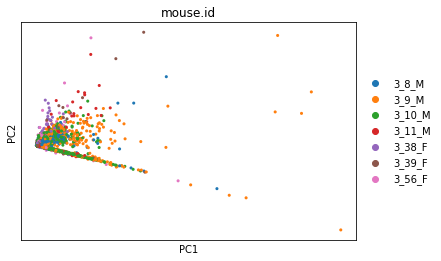

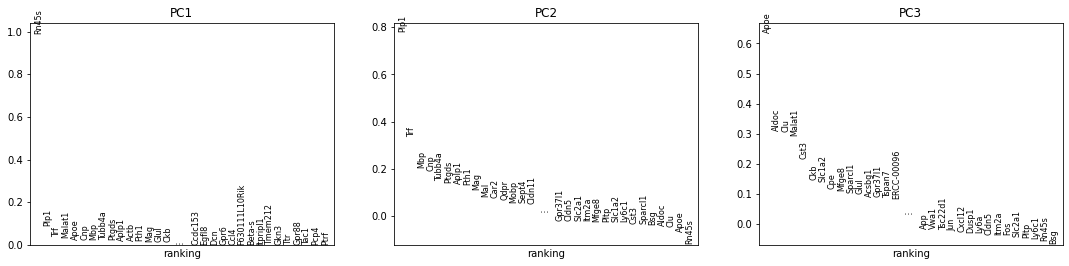

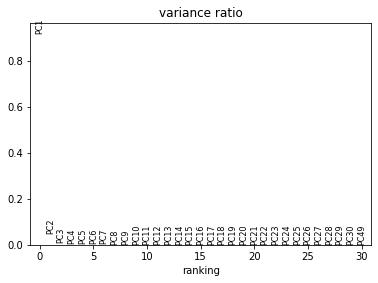

In [31]:
sc.pl.pca_overview(adata, color='mouse.id')

In [32]:
adata.uns

OverloadedDict, wrapping:
	OrderedDict([('pca', {'params': {'zero_center': True, 'use_highly_variable': False}, 'variance': array([7.5778212e+10, 3.8194284e+09, 6.9450016e+08, 3.0848496e+08,
       2.6322722e+08, 2.1384595e+08, 1.7025264e+08, 1.3616726e+08,
       8.2641640e+07, 5.9008440e+07, 4.8047240e+07, 4.6198464e+07,
       4.1371828e+07, 3.1640170e+07, 3.0767336e+07, 2.8293064e+07,
       2.5999976e+07, 2.2749784e+07, 2.1087520e+07, 1.8888068e+07,
       1.6900656e+07, 1.5758153e+07, 1.4826150e+07, 1.3796459e+07,
       1.3365402e+07, 1.1948504e+07, 1.1131909e+07, 1.0620610e+07,
       1.0337827e+07, 9.8309680e+06, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32), 'variance_ratio': 

In [33]:
adata.varm['PCs'].shape

(18585, 50)

In [34]:
adata.varm['PCs']

array([[ 3.9055919e-07, -1.0433929e-06,  5.0195399e-06, ...,
         7.3680198e-03, -6.5966598e-03,  1.7509687e-03],
       [ 5.0403376e-04,  7.0064166e-04,  3.0028035e-03, ...,
        -2.2495973e-03,  2.7329798e-03,  8.6857565e-03],
       [ 9.6375785e-05, -1.5663065e-04, -1.3447669e-04, ...,
        -1.4722464e-03,  4.4758255e-03,  2.1788592e-03],
       ...,
       [ 6.2857536e-05,  8.2134517e-05,  1.0080084e-04, ...,
        -1.1274464e-02,  1.8083097e-03, -3.5258692e-03],
       [ 4.9997908e-08, -2.7915507e-07, -4.3406507e-07, ...,
         7.3121069e-03,  2.0389084e-03,  5.9392676e-03],
       [ 2.2447585e-04, -1.4651155e-04,  1.6835080e-03, ...,
        -1.1374482e-02, -4.9550929e-03, -5.2181347e-03]], dtype=float32)

In [35]:
adata.obsm['X_pca'].shape

(3210, 50)

In [36]:
adata.obsm['X_pca']

array([[-184242.34  ,  -13552.693 ,    2397.3357, ...,       0.    ,
             -0.    ,       0.    ],
       [-164747.28  ,  -19324.443 ,   51527.887 , ...,      -0.    ,
             -0.    ,       0.    ],
       [   9067.189 ,   80857.11  ,    6444.881 , ...,       0.    ,
              0.    ,       0.    ],
       ...,
       [-180811.89  ,  -14364.947 ,   -4025.456 , ...,       0.    ,
              0.    ,       0.    ],
       [ -44791.92  ,   13990.074 ,   -3556.254 , ...,       0.    ,
              0.    ,      -0.    ],
       [-184896.12  ,  -14003.798 ,    2183.3135, ...,       0.    ,
              0.    ,       0.    ]], dtype=float32)

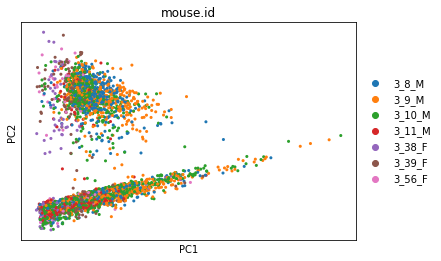

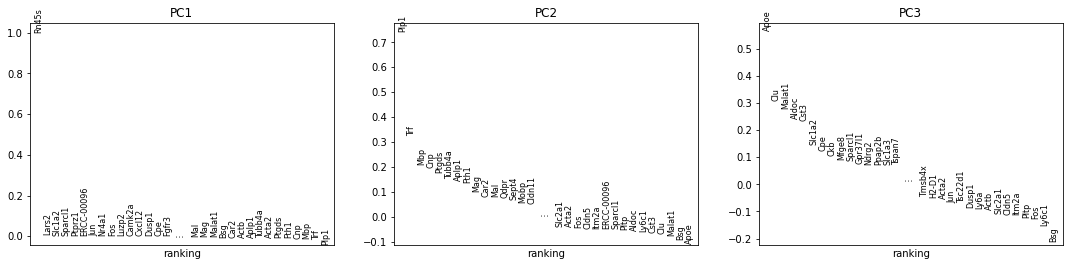

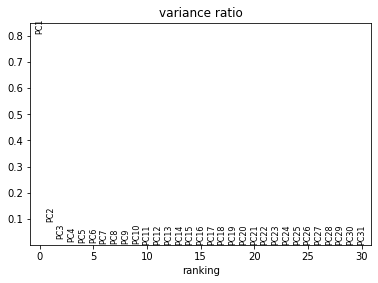

In [37]:
adata_norm1 = adata.copy()
adata_norm1.raw = adata_norm1
sc.pp.normalize_per_cell(adata_norm1, counts_per_cell_after=1e6)
sc.pp.pca(adata_norm1)
sc.pl.pca_overview(adata_norm1, color='mouse.id')

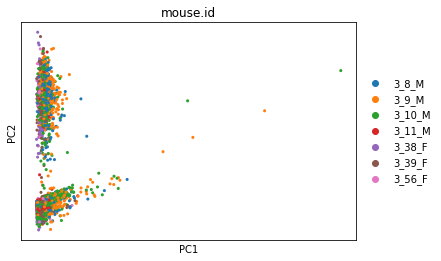

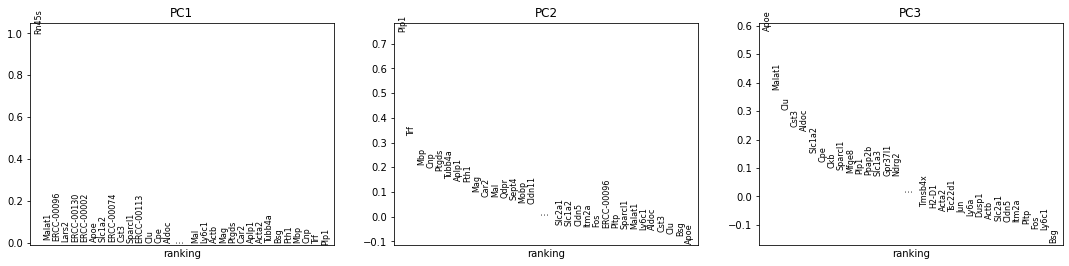

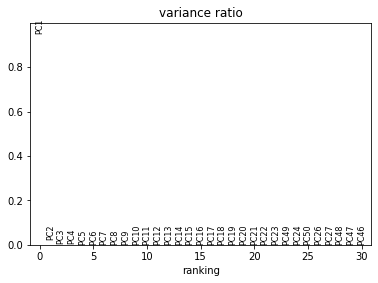

In [38]:
adata_norm2 = adata.copy() # make a copy so we can compare results
sc.pp.normalize_total(adata_norm2, target_sum=1e6, exclude_highly_expressed=True) # normalize
sc.pp.pca(adata_norm2) # run pca
sc.pl.pca_overview(adata_norm2, color='mouse.id')

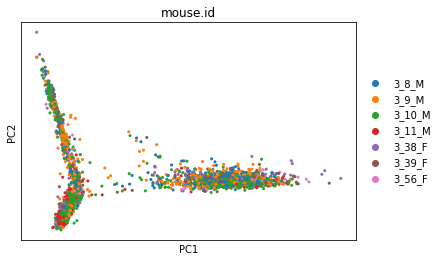

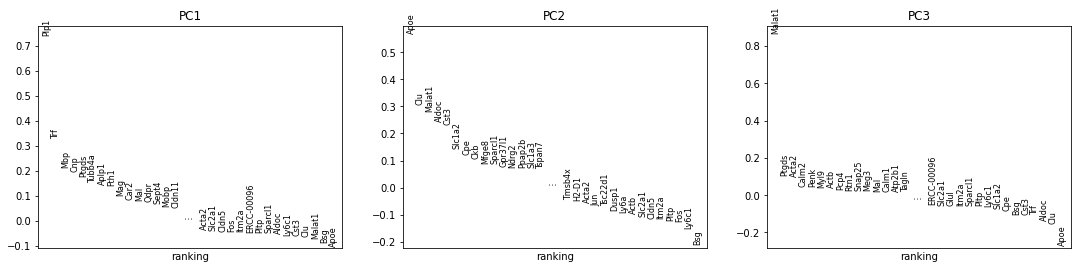

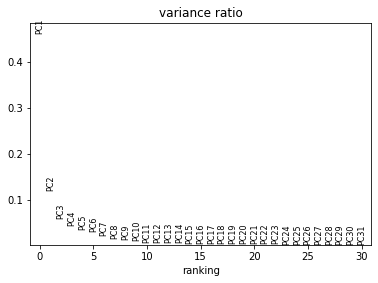

In [39]:
not_Rn45s = adata_norm1.var.index != 'Rn45s'
adata_no_Rn45s = adata_norm1[:, not_Rn45s]

sc.pp.pca(adata_no_Rn45s)
sc.pl.pca_overview(adata_no_Rn45s, color='mouse.id')

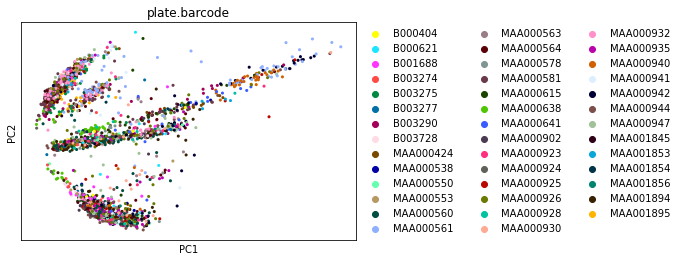

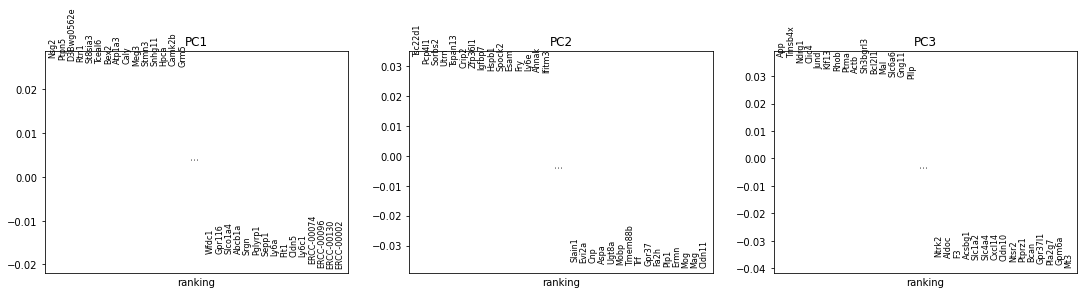

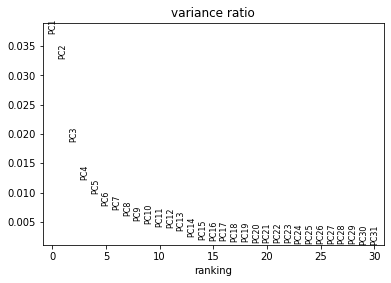

In [40]:
sc.pp.log1p(adata_norm1)  # Returns or updates data, depending on copy. X = log(X + 1) 
sc.pp.scale(adata_norm1)  # Scale data to unit variance and zero mean.
# updates adata with a scaled adata.X, annotated with 'mean' and 'std' in adata.var.
sc.pp.pca(adata_norm1)
sc.pl.pca_overview(adata_norm1, color='plate.barcode')

In [41]:
adata_norm1.write('brain_normalized.h5ad')

## Dimensionality reduction and clustering

### tSNE

In [42]:
adata_norm1.var.head()

,ERCC,n_cells,n_counts,mean,std
0610005C13Rik,False,28,402.0,0.016376,0.202364
0610007C21Rik,False,2358,686914.0,3.775246,2.542979
0610007L01Rik,False,951,122212.0,1.127669,1.956620
0610007N19Rik,False,266,21897.0,0.295270,1.082449
0610007P08Rik,False,577,55529.0,0.621058,1.495668


In [43]:
adata_norm1.obs.head()

,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts
cell,,,,,,,
A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0
A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0
A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616084.0
A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0
A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0


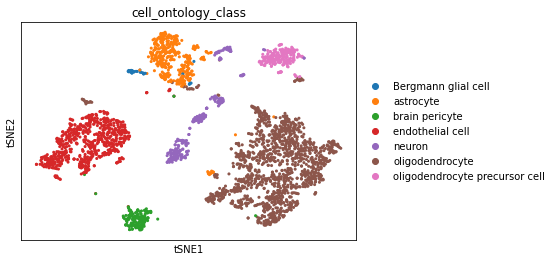

In [44]:
sc.tl.tsne(adata_norm1,
           perplexity=30,
           learning_rate=1000,
           random_state=0)

sc.pl.tsne(adata_norm1, color='cell_ontology_class')

### UMAP

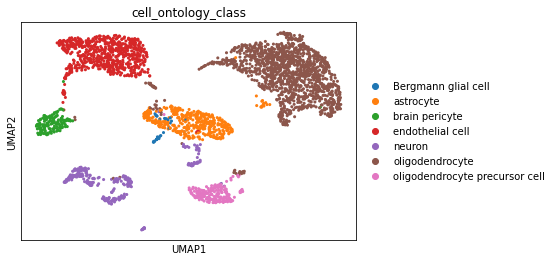

In [45]:
sc.pp.neighbors(adata_norm1)
sc.tl.umap(adata_norm1,
           min_dist=0.5,
           spread=1.0,
           random_state=1,
           n_components=2)

sc.pl.umap(adata_norm1, color='cell_ontology_class')

### KMeans

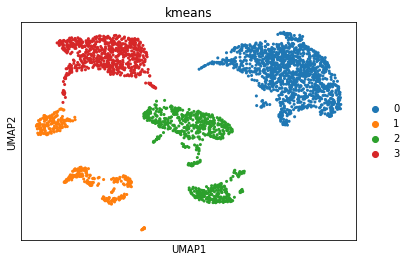

In [46]:
umap_coordinates = adata_norm1.obsm['X_umap'] # extract the UMAP coordinates for each cell
kmeans = KMeans(n_clusters=4, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata_norm1.obs['kmeans'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata_norm1.obs['kmeans'] = adata_norm1.obs['kmeans'].astype(str)

sc.pl.umap(adata_norm1, color='kmeans')

In [47]:
kmeans.labels_

array([2, 2, 0, ..., 3, 0, 2], dtype=int32)

In [48]:
adata_norm1.obs.head()

,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts,kmeans
cell,,,,,,,,
A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0,2
A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0,2
A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616084.0,0
A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0,3
A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0,2


In [49]:
adata_norm1.obs['cell_ontology_class'].unique()

['astrocyte', 'oligodendrocyte', 'endothelial cell', 'neuron', 'oligodendrocyte precursor cell', 'Bergmann glial cell', 'brain pericyte']
Categories (7, object): ['Bergmann glial cell', 'astrocyte', 'brain pericyte', 'endothelial cell', 'neuron', 'oligodendrocyte', 'oligodendrocyte precursor cell']

In [50]:
rand_index = adjusted_rand_score(labels_true=adata_norm1.obs['cell_ontology_class'],
                                 labels_pred = adata_norm1.obs['kmeans'])
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.85


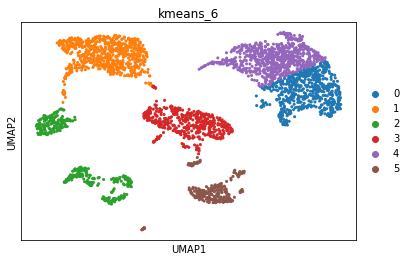

In [51]:
umap_coordinates = adata_norm1.obsm['X_umap'] # extract the UMAP coordinates for each cell
kmeans = KMeans(n_clusters=6, random_state=0).fit(umap_coordinates) # fix the random state for reproducibility

adata_norm1.obs['kmeans_6'] = kmeans.labels_ # retrieve the labels and add them as a metadata column in our AnnData object
adata_norm1.obs['kmeans_6'] = adata_norm1.obs['kmeans_6'].astype(str)

sc.pl.umap(adata_norm1, color='kmeans_6')

In [52]:
rand_index = adjusted_rand_score(labels_true=adata_norm1.obs['cell_ontology_class'],
                                 labels_pred=adata_norm1.obs['kmeans_6'])
print('The Rand index is', round(rand_index, 2))

The Rand index is 0.64


### Graph-base methods

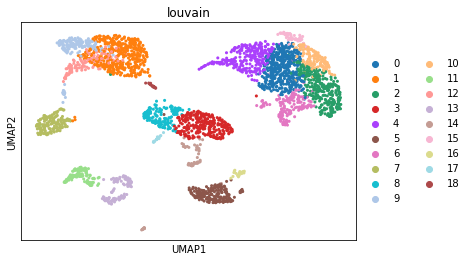

In [53]:
louvain(adata_norm1)  # Cluster cells into subgroups # adata.obs['louvain']
sc.pl.umap(adata_norm1, color='louvain')

In [54]:
adata_norm1.obs.head()

,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts,kmeans,kmeans_6,louvain
cell,,,,,,,,,,
A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0,2,3,3
A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0,2,3,8
A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616084.0,0,4,0
A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0,3,1,9
A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0,2,3,8


In [55]:
rand_index = adjusted_rand_score(adata_norm1.obs['cell_ontology_class'],
                                 adata_norm1.obs['louvain'])
print('The rand index is ', round(rand_index, 2))

The rand index is  0.36


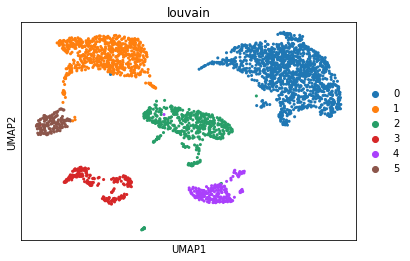

The rand index is  0.91


In [56]:
louvain(adata_norm1, resolution=0.1)  # Cluster cells into subgroups # adata.obs['louvain']
sc.pl.umap(adata_norm1, color='louvain')

rand_index = adjusted_rand_score(adata_norm1.obs['cell_ontology_class'],
                                 adata_norm1.obs['louvain'])
print('The rand index is ', round(rand_index, 2))

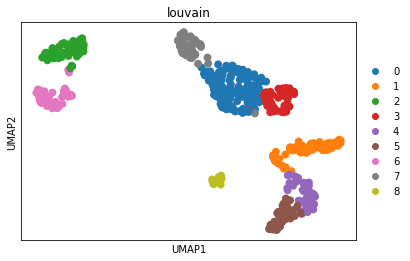

In [57]:
cerebellum = adata_norm1[adata_norm1.obs['subtissue'] == 'Cerebellum']
sc.pp.neighbors(cerebellum)
sc.tl.umap(cerebellum)

sc.tl.louvain(cerebellum)
sc.pl.umap(cerebellum, color='louvain')

In [58]:
sc.tl.louvain(adata_norm1, resolution=0.1)
adata_norm1.write('brain_clusters.h5ad')

## Differential expression analysis

In [59]:
adata_norm1.obs.cell_ontology_class.unique()

['astrocyte', 'oligodendrocyte', 'endothelial cell', 'neuron', 'oligodendrocyte precursor cell', 'Bergmann glial cell', 'brain pericyte']
Categories (7, object): ['Bergmann glial cell', 'astrocyte', 'brain pericyte', 'endothelial cell', 'neuron', 'oligodendrocyte', 'oligodendrocyte precursor cell']

In [60]:
raw = pd.DataFrame(data=adata_norm1.raw.X,
                   index=adata_norm1.raw.obs_names,
                   columns=adata_norm1.raw.var_names)

In [61]:
astrocyte_marker = 'Gja1' # define genes of interest
# housekeeping = 'Chmp2a' 

cluster2 = raw[adata_norm1.obs['louvain'] == '2'] # Use a mask to subset dataset to cells assigned to cluster 2
not_cluster2 = raw[adata_norm1.obs['louvain'] != '2']

cluster2.head()

,0610005C13Rik,0610007C21Rik,0610007L01Rik,0610007N19Rik,0610007P08Rik,0610007P14Rik,0610007P22Rik,0610009B14Rik,0610009B22Rik,0610009D07Rik,...,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,a,l7Rn6
cell,,,,,,,,,,,,,,,,,,,,,
A1.B003290.3_38_F.1.1,0.0,125.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0
A1.B003728.3_56_F.1.1,0.0,0.0,0.0,0.0,0.0,324.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1.MAA000923.3_9_M.1.1,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0
A1.MAA000930.3_8_M.1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,587.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
A10.MAA000926.3_9_M.1.1,0.0,136.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,76.0,181.0,0.0,129.0


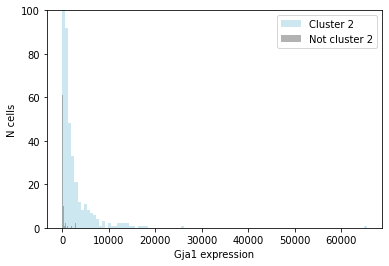

In [62]:
cluster2_marker_exp = cluster2[astrocyte_marker]

plt.hist(cluster2_marker_exp.values,
         bins=100,
         color='lightblue',
         alpha=0.6,
         label='Cluster 2')

not_cluster2_marker_exp = not_cluster2[astrocyte_marker]  # # getting the values for all cells not belonging to cluster 2 for the specific gene
plt.hist(not_cluster2_marker_exp,
         bins=100,
         color='gray',
         alpha=0.6,
         label='Not cluster 2')

plt.ylim(0,100)
plt.xlabel('%s expression' % astrocyte_marker)
plt.ylabel('N cells')
plt.legend()

### T-Test

In [63]:
ttest = ttest_ind(cluster2_marker_exp, 
                  not_cluster2_marker_exp, 
                  equal_var=False,
                  nan_policy='omit')
print(ttest)

Ttest_indResult(statistic=10.472000376695075, pvalue=2.3204030965250666e-23)


/home/kiddos/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/kiddos/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/kiddos/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/kiddos/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/kiddos/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/kiddos/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_gro

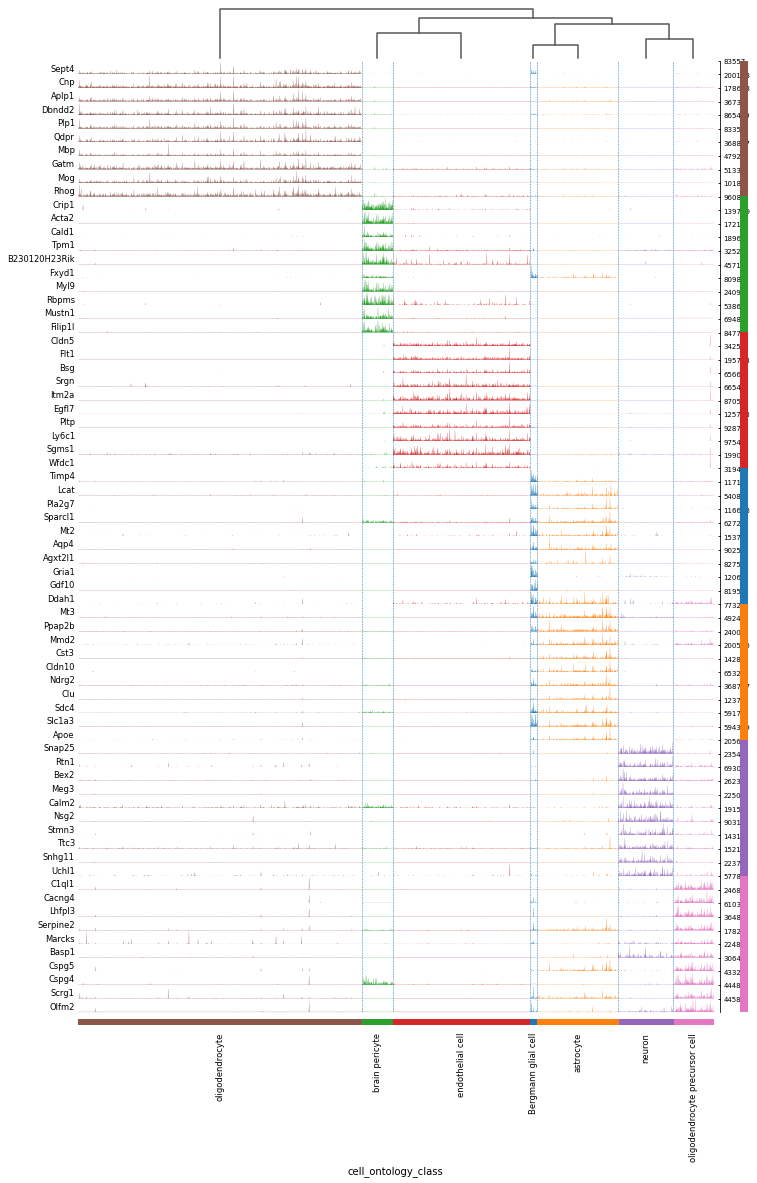

In [64]:
sc.tl.rank_genes_groups(adata_norm1,
                        groupby='cell_ontology_class',
                        use_raw=True, 
                        method='t-test_overestim_var',
                        n_genes=10)

sc.pl.rank_genes_groups_tracksplot(adata_norm1,
                                   groupby='cell_ontology_class')

/home/kiddos/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/kiddos/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/kiddos/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: invalid value encountered in true_divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/kiddos/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/kiddos/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/kiddos/.local/lib/python3.8/site-packages/scanpy/tools/_rank_genes_gro

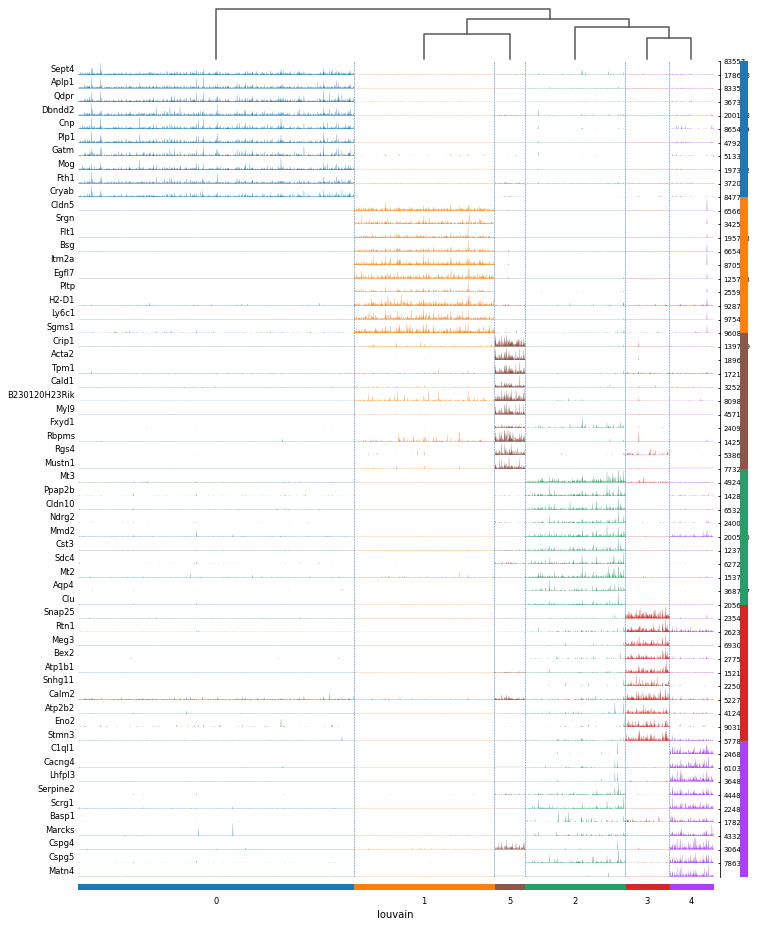

In [65]:
sc.tl.rank_genes_groups(adata_norm1,
                        groupby='louvain',
                        use_raw=True, 
                        method='t-test_overestim_var',
                        n_genes=10)
sc.pl.rank_genes_groups_tracksplot(adata_norm1, groupby='louvain')

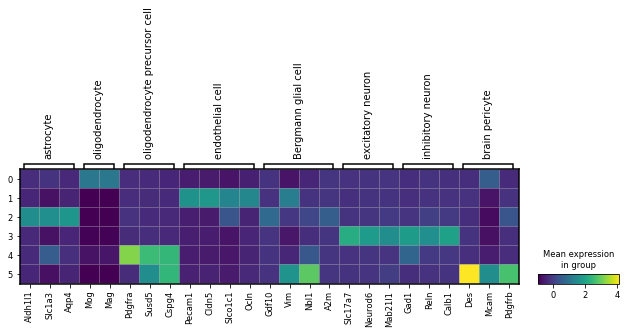

In [66]:
marker_genes = {
    'astrocyte': ['Aldh1l1', 'Slc1a3', 'Aqp4'], 
    'oligodendrocyte': ['Mog','Mag'],
    'oligodendrocyte precursor cell': ['Pdgfra','Susd5','Cspg4'],
    'endothelial cell': ['Pecam1','Cldn5','Slco1c1','Ocln'],
    'Bergmann glial cell': ['Gdf10','Vim','Nbl1','A2m'],
    'excitatory neuron': ['Slc17a7','Neurod6','Mab21l1'],
    'inhibitory neuron': ['Gad1','Reln','Calb1'],
    'brain pericyte': ['Des','Mcam','Pdgfrb']
}

sc.pl.matrixplot(adata_norm1,
                 marker_genes,
                 groupby='louvain',
                 use_raw=False)